# Purpose

The purpose of this notebook is to demonstrate prior and predictive checks of one's causal graphical model.

The prior checks are to be used as part of one's falsification efforts before estimating the posterior distribution of one's unknown model parameters. If one's causal model contains latent variables, then such prior checks are expected to be extremely valuable. They are expected to indicate when one's model is likely to poorly fit one's data. This information can be used to avoid a potentially lengthy model estimation process. These checks will likely be implemented with very liberal thresholds for deciding that a model is not even worth beign estimated.

The posterior predictive checks are to really ensure that the observed data is well fit by the assumptions of one's causal model.

# Logical steps
0. Determine the test statistic to be computed.
1. Require as inputs:
   1. predictive samples of all model variables (latent and observed),
   2. function to compute the desired test statistic given a sample from the causal graph,
   3. the observed data.
   4. function to plot the distribution of the simulated test statistic and the value/distribution of the observed test statistic.
2. For each predictive sample,
   1. Compute the value of the simulated and observed test statistic (assuming the observed test statistic also depends on the simulated values. If not, simply store the value of the observed test statistic and do not recompute it.)
   2. Store the simulated and observed test statistics.
3. Visualize the distribution of the simulated and observed test statistics.
4. Produce a scalar summary of the distribution of simulated test statistics if desired.

## Declare notebook parameters

In [1]:
# Declare hyperparameters for testing
MIN_SAMPLES_LEAF = 40
NUM_PERMUTATIONS = 100

# Declare the columns to be used for testing
x1_col = 'num_licensed_drivers'
x2_col = 'num_cars'
mode_id_col = 'mode_id'

# Set the colors for plotting
ORIG_COLOR = '#045a8d'
SIMULATED_COLOR = '#a6bddb'

# Declare paths to data
DATA_PATH =\
    '../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'

## Execute needed imports

In [2]:
import sys
from pdb import set_trace as bp

import numpy as np
import pandas as pd
from scipy.stats import norm

import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from causalgraphicalmodels import CausalGraphicalModel

sys.path.insert(0, '../../src/')
import viz

## Create needed functions for analysis

In [3]:
def _make_regressor(x_2d, y, seed=None):
    # regressor_kwargs =\
    #     regressor = LinearRegression()
    #     {'min_samples_leaf': MIN_SAMPLES_LEAF,
    #      'max_samples': 0.8}
    # if seed is not None:
    #     regressor_kwargs['random_state'] = seed + 10
    # regressor =\
    #     RandomForestRegressor(**regressor_kwargs)
    regressor = LinearRegression()
    regressor.fit(x_2d, y)
    return regressor


def computed_vs_obs_r2(x1_array,
                       x2_array,
                       z_array,
                       seed,
                       progress=True):
    # Combine the various predictors
    combined_obs_predictors =\
        np.concatenate((x2_array[:, None], z_array[:, None]), axis=1)

    # Determine the number of rows being plotted
    num_rows = x1_array.shape[0]

    # Create a regressor to be used to compute the conditional expectations
    regressor = _make_regressor(combined_obs_predictors, x1_array, seed)

    # Get the observed expectations
    obs_expectation = regressor.predict(combined_obs_predictors)
    obs_r2 = r2_score(x1_array, obs_expectation)

    # Initialize arrays to store the permuted expectations and r2's
    permuted_expectations = np.empty((num_rows, NUM_PERMUTATIONS))
    permuted_r2 = np.empty(NUM_PERMUTATIONS, dtype=float)

    # Get the permuted expectations
    shuffled_index_array = np.arange(num_rows)

    iterable = range(NUM_PERMUTATIONS)
    if progress:
        iterable = tqdm(iterable)

    for i in iterable:
        # Shuffle the index array
        np.random.shuffle(shuffled_index_array)
        # Get the new set of permuted X_2 values
        current_x2 = x2_array[shuffled_index_array]
        # Get the current combined predictors
        current_predictors =\
            np.concatenate((current_x2[:, None], obs_z[:, None]), axis=1)
        # Fit a new model and store the current expectation
        current_regressor =\
            _make_regressor(current_predictors, x1_array, seed)
        permuted_expectations[:, i] =\
            current_regressor.predict(current_predictors)
        permuted_r2[i] = r2_score(x1_array, permuted_expectations[:, i])
    return obs_r2, permuted_r2


def compute_pvalue(obs_r2, permuted_r2):
    return (obs_r2 < permuted_r2).mean()


def compute_predictive_independence_test_values(samples, obs_sample, seed):
    """
    test_values = p-values of conditional independence test
    """
    # Determine the number of samples in order to create an iterable for
    # getting and storing test samples
    if len(samples.shape != 3):
        msg = '`samples` should have shape (num_rows, 3, num_samples).'
        raise ValueError(msg)
    num_samples = samples.shape[-1]

    # Initialize a container for the p-values of the sampled and observed data
    sampled_pvals = np.empty((num_samples,), dtype=float)
    obs_pvals = np.empty((num_samples,), dtype=float)

    # Create the iterable to be looped over to compute test values
    iterable = range(NUM_PERMUTATIONS)
    if progress:
        iterable = tqdm(iterable)

    # Populate the arrays of test statistics
    for i in iterable:
        # Get the data to be used to calculate this set of p-values
        current_sim_sample = samples[:, :, i]
        current_sim_z = current_sim_sample[:, -1]
        current_augmented_obs = np.concatenate((obs_samples, current_sim_z))

        # Package the arguments to compute the predictive r2 values
        sim_args =\
            (current_sim_sample[:, 0],
             current_sim_sample[:, 1],
             current_sim_z,
             seed,
             False
            )

        augmented_obs_args =\
            (current_augmented_obs[:, 0],
             current_augmented_obs[:, 1],
             current_augmented_obs[:, 2],
             seed,
             False
            )

        # Compute and store the p-values of the conditional independence
        # test for the current simulated and augmented dataset
        sampled_pvals[i] =\
            compute_pvalue(computed_vs_obs_r2(*sim_args))

        obs_pvals[i] =\
            compute_pvalue(computed_vs_obs_r2(*augmented_obs_args))
    return sampled_pvals, obs_pvals


def visualize_predictive_cit_results(
        sampled_pvals,
        obs_pvals,
        verbose=True,
        show=True,
        close=False):
    fig, ax = plt.subplots(figsize=(10, 6))
    overall_p_value = (obs_pvals < sampled_pvals).mean()

    if verbose:
        msg =\
            'The p-value of the predictive, permutation C.I.T. is {:.2f}.'
        print(msg.format(overall_p_value))

    sbn.kdeplot(
        sampled_pvals, ax=ax, color=SIMULATED_COLOR, label='Simulated')
    sbn.kdeplot(
        obs_pvals, ax=ax, color=ORIG_COLOR, label='Observed')

    ax.set_xlabel('Permutation P-value', fontsize=13)
    ax.set_ylabel(
        'Density', fontdict={'fontsize':13, 'rotation':0}, labelpad=40)
    ax.legend(loc='best')
    sbn.despine()
    if show:
        fig.show()
    if close:
        plt.close(fig=fig)
    return overall_p_value


def perform_visual_predictive_cit_test(
        samples,
        obs_sample,
        seed=1038,
        verbose=True,
        show=True,
        close=False):
    """
    Parameters
    ----------
    samples : 3D ndarray of shape (num_rows, 3, num_samples).
        Columns should contain, in order, simulated x1, x2, z.
    obs_sample : 2D ndarray of shape (num_rows, 2)
        Columns should contain, in order, observed x1, observed x2.
    """
    # Set a random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Compute the observed and sampled pvalues
    sampled_pvals, obs_pvals =\
        compute_predictive_independence_test_values(
            samples, obs_sample, seed)

    # Visualize the results of the predictive permutation CIT test
    overall_p_value =\
        visualize_predictive_cit_results(
            sampled_pvals, obs_pvals, verbose=verbose, show=show, close=close)
    return p_value




## Extract data for the factor model checks

In [4]:
# Load the raw data
df = pd.read_csv(DATA_PATH)

In [6]:
# Get the values to be used for testing
filter_array = (df[mode_id_col] == 1).values
obs_x1 = df[x1_col].values[filter_array]
obs_x2 = df[x2_col].values[filter_array]
obs_sample =\
    np.concatenate((obs_x1[:, None], obs_x2[:, None]), axis=1)

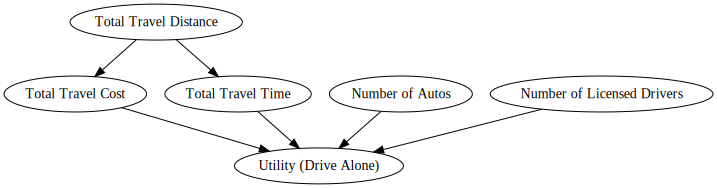

In [8]:
# Note the variables that take part in the drive alone utility
# The following cell is taken from 5.0pmab-simulation-causal-graph.ipynb
V_Drive_Alone =\
    CausalGraphicalModel(
        nodes=["Total Travel Distance",
               "Total Travel Time",
               "Total Travel Cost",
               "Number of Autos",
               "Number of Licensed Drivers",
               "Utility (Drive Alone)"],
         edges=[("Total Travel Distance","Total Travel Time"),
                ("Total Travel Distance","Total Travel Cost"),
                ("Total Travel Time", "Utility (Drive Alone)"), 
                ("Total Travel Cost", "Utility (Drive Alone)"), 
                ("Number of Autos", "Utility (Drive Alone)"),
                ("Number of Licensed Drivers","Utility (Drive Alone)")
    ]
)

# draw the causal model
V_Drive_Alone.draw()

In [13]:
# Create a list of the variables in the drive alone utility
drive_alone_variables =\
    ['total_travel_distance',
     'total_travel_cost',
     'total_travel_time',
     'num_cars',
     'num_licensed_drivers'
    ]

# Create a sub-dataframe with those variables
drive_alone_df =\
    df.loc[df['mode_id'] == 1, drive_alone_variables]

# Get the means and standard deviations of those variables
drive_alone_means = drive_alone_df.mean()
drive_alone_means.name = 'mean'

drive_alone_stds = drive_alone_df.std()
drive_alone_stds.name = 'std'

# Look at the computed means and standard deviations
print(pd.DataFrame([drive_alone_means, drive_alone_stds]))

      total_travel_distance  total_travel_cost  total_travel_time  num_cars  \
mean              15.579498           3.289287          29.667137  2.050999   
std               18.465879           4.214448          24.586569  0.880458   

      num_licensed_drivers  
mean              2.178759  
std               0.751621  


## Specify the factor model that is to be checked

In Wang and Blei's deconfounder technique, we fit a factor model to the variables in one's outcome model.

The factor model being considered here is:

$
\begin{aligned}
X_{\textrm{standardized}} &= Z * W + \epsilon\\
\textrm{where } \epsilon &= \left[ \epsilon_1, \epsilon_2, ..., \epsilon_D \right]\\
\epsilon_d &\in \mathbb{R}^{\textrm{N x 1}}\\
\epsilon_d &\sim \mathcal{N} \left(0, \sigma \right) \forall d \in \left\lbrace 1, 2, ... D \right\rbrace\\
Z &\in \mathbb{R}^{\textrm{N x 1}}\\
Z &\sim \mathcal{N} \left(0, 1 \right)\\
W &\in \mathbb{R}^{1 x D}\\
W &\sim \mathcal{N} \left(0, 1 \right)\\
N &= \textrm{Number of rows in X_standardized}\\
D &= \textrm{Number of columns in X_standardized}
\end{aligned}
$

In [ ]:
# Specify the prior for the factor model of the standardized drive alone dataframe
w_prior_dist = norm()